<Axes: >

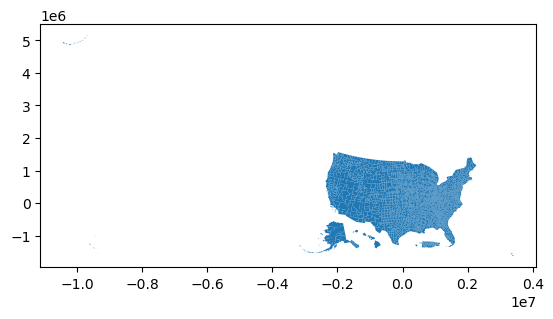

In [1]:
# generate plot by county
from pygris import counties
from pygris.utils import shift_geometry

analysis_year = 2017
us_counties = counties(year = analysis_year)
us_counties = shift_geometry(us_counties)
us_counties.plot()

['31' '53' '35' '46' '48' '06' '21' '39' '01' '13' '55' '05' '41' '42'
 '28' '29' '08' '37' '49' '40' '51' '47' '56' '54' '22' '36' '26' '18'
 '25' '20' '16' '12' '78' '32' '17' '50' '09' '30' '34' '27' '38' '24'
 '19' '45' '23' '33' '04' '10' '11' '66' '69' '60' '44' '02' '15' '72']


<Axes: >

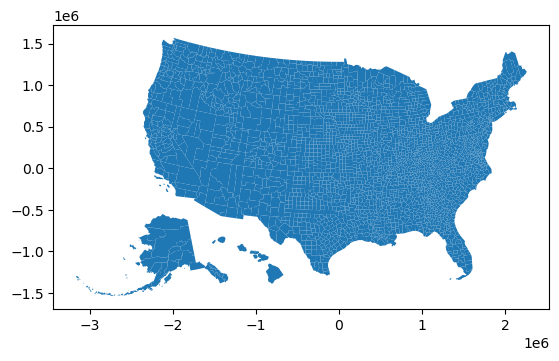

In [6]:
print(us_counties.STATEFP.unique())
state_fips_to_drop = ['72', '78', '66', '69', '60']
us_counties = us_counties.loc[~us_counties['STATEFP'].isin(state_fips_to_drop)]
us_counties.plot()

In [7]:
# additional packages
from sklearn_extra.cluster import CLARA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
from pandas import read_csv
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('C:\SynthFirm')

In [8]:
# define scenario
scenario_name = 'national'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + scenario_name
plot_dir = 'plots_' + scenario_name
lehd_file = 'US_naics.csv'
map_file = scenario_name + '_freight.geojson'


In [9]:
# load model results
synthfirm_all = read_csv(os.path.join(output_dir, 'synthetic_firms_v2.csv'))
region_map = gpd.read_file(os.path.join(input_dir, map_file))
mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))
lehd_validation = read_csv(os.path.join(input_dir, lehd_file))
synthfirm_output = read_csv(os.path.join(output_dir, 'processed_b2b_flow_summary_mesozone.csv'))

In [10]:
# generate attributes needed by all sectors

# geoid +  land area
us_counties.loc[:, 'area'] = (us_counties.loc[:, 'ALAND'] + us_counties.loc[:, 'AWATER'])/ 1000000
us_counties.loc[:, 'GEOID'] = us_counties.loc[:, 'GEOID'].astype(int)

us_county_df = pd.DataFrame(us_counties.drop(columns = 'geometry'))
us_county_df.head(5)

cluster_df = us_county_df[['GEOID', 'area']]

# spatial crosswalk
mesozone_to_county = mesozone_id_lookup[['MESOZONE', 'CBPZONE']]
mesozone_to_county.loc[:, 'MESOZONE'] = mesozone_to_county.loc[:, 'MESOZONE'].astype(np.int64)

# D1 - density

In [11]:
# Firm and emp density
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, 
                        on = 'MESOZONE', how = 'left')

firm_attr_by_county = firm_by_zone.groupby('CBPZONE')[['firm_count', 'employment_count']].sum()
firm_attr_by_county = firm_attr_by_county.reset_index()
firm_attr_by_county.loc[:, 'CBPZONE'] = firm_attr_by_county.loc[:, 'CBPZONE'].astype(int)
firm_attr_by_county.rename(columns = {'CBPZONE': 'GEOID'}, inplace = True)


cluster_df_d1 = pd.merge(cluster_df, firm_attr_by_county, on='GEOID', how='left')
cluster_df_d1.loc[:, 'firm_per_area'] = \
cluster_df_d1.loc[:, 'firm_count'] / cluster_df_d1.loc[:, 'area']
cluster_df_d1.loc[:, 'emp_per_area'] = \
cluster_df_d1.loc[:, 'employment_count'] / cluster_df_d1.loc[:, 'area']

cluster_df_d1.head(5)

firm_count          8.418623e+06
employment_count    1.471677e+08
dtype: float64


,GEOID,area,firm_count,employment_count,firm_per_area,emp_per_area
0,31039,1488.343176,476,4119.0,0.319819,2.767507
1,53069,742.545193,97,617.0,0.130632,0.830926
2,35011,6045.908993,73,371.0,0.012074,0.061364
3,31109,2192.120047,8943,179153.0,4.079612,81.725907
4,31129,1491.363670,207,1433.0,0.138799,0.960866


In [12]:
# production density


production_in_region = synthfirm_output.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})
production_in_region['MESOZONE'] = \
production_in_region['MESOZONE'].astype(np.int64)

production_by_county = pd.merge(production_in_region, mesozone_to_county, 
                               on = 'MESOZONE', how = 'left')
production_by_county = production_by_county.groupby('CBPZONE')[['ShipmentLoad']].sum()
production_by_county = production_by_county.reset_index()
production_by_county.loc[:, 'CBPZONE'] = production_by_county.loc[:, 'CBPZONE'].astype(int)
production_by_county.rename(columns = {'CBPZONE': 'GEOID', 'ShipmentLoad': 'production'}, inplace = True)


cluster_df_d1 = \
pd.merge(cluster_df_d1, production_by_county, on='GEOID', how='left')
cluster_df_d1.loc[:, 'production_per_area'] = \
cluster_df_d1.loc[:, 'production'] * 0.907185/ \
cluster_df_d1.loc[:, 'area']

cluster_df_d1.head(5)

,GEOID,area,firm_count,employment_count,firm_per_area,emp_per_area,production,production_per_area
0,31039,1488.343176,476,4119.0,0.319819,2.767507,2261.457360,1.378419
1,53069,742.545193,97,617.0,0.130632,0.830926,537.105328,0.656194
2,35011,6045.908993,73,371.0,0.012074,0.061364,22.120889,0.003319
3,31109,2192.120047,8943,179153.0,4.079612,81.725907,2054.293714,0.850147
4,31129,1491.363670,207,1433.0,0.138799,0.960866,242.702085,0.147634


In [13]:
# attraction density
attraction_in_region = synthfirm_output.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})
attraction_in_region['MESOZONE'] = \
attraction_in_region['MESOZONE'].astype(np.int64)

attraction_by_county = pd.merge(attraction_in_region, mesozone_to_county, 
                               on = 'MESOZONE', how = 'left')
attraction_by_county = attraction_by_county.groupby('CBPZONE')[['ShipmentLoad']].sum()
attraction_by_county = attraction_by_county.reset_index()
attraction_by_county.loc[:, 'CBPZONE'] = attraction_by_county.loc[:, 'CBPZONE'].astype(int)
attraction_by_county.rename(columns = {'CBPZONE': 'GEOID', 'ShipmentLoad': 'consumption'}, inplace = True)
attraction_by_county.head(5)

cluster_df_d1 = \
pd.merge(cluster_df_d1, attraction_by_county, on='GEOID', how='left')
cluster_df_d1.loc[:, 'consumption_per_area'] = \
cluster_df_d1.loc[:, 'consumption'] * 0.907185/ \
cluster_df_d1.loc[:, 'area']

cluster_df_d1.head(5)

,GEOID,area,firm_count,employment_count,firm_per_area,emp_per_area,production,production_per_area,consumption,consumption_per_area
0,31039,1488.343176,476,4119.0,0.319819,2.767507,2261.457360,1.378419,1917.088616,1.168517
1,53069,742.545193,97,617.0,0.130632,0.830926,537.105328,0.656194,66.173871,0.080846
2,35011,6045.908993,73,371.0,0.012074,0.061364,22.120889,0.003319,24.627115,0.003695
3,31109,2192.120047,8943,179153.0,4.079612,81.725907,2054.293714,0.850147,21828.240031,9.033379
4,31129,1491.363670,207,1433.0,0.138799,0.960866,242.702085,0.147634,554.954595,0.337575


# D2 - diversity

In [14]:
# 2-digit NAICS
synthfirm_all.loc[:, 'industry'] = synthfirm_all.loc[:, 'Industry_NAICS6_Make'].astype(str).str[0:2]
synthfirm_all.loc[synthfirm_all['industry'].isin(["31", "32", "33"]), 'industry'] = "3133"
synthfirm_all.loc[synthfirm_all['industry'].isin(["44", "45", "4A"]), 'industry'] = "4445"
synthfirm_all.loc[synthfirm_all['industry'].isin(["48", "49"]), 'industry'] = "4849"
synthfirm_all.loc[synthfirm_all['industry'].isin(["S0"]), 'industry'] = "92"

firm_by_zone_ind = synthfirm_all.groupby(['MESOZONE', 'industry']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone_ind = firm_by_zone_ind.reset_index()
firm_by_zone_ind.columns = ['MESOZONE', 'industry', 'firm_count', 'employment_count']


firm_by_zone_ind = pd.merge(firm_by_zone_ind, mesozone_id_lookup, 
                        on = 'MESOZONE', how = 'left')
firm_by_zone_ind.head(5)


,MESOZONE,industry,firm_count,employment_count,GEOID,FAFID,CBPZONE,FAFNAME
0,10010201001,23,2,36.538546,10010201001,19,1001,Rest of AL
1,10010201001,4849,2,34.471523,10010201001,19,1001,Rest of AL
2,10010201001,81,6,23.219713,10010201001,19,1001,Rest of AL
3,10010202001,4849,12,201.357576,10010202001,19,1001,Rest of AL
4,10010202001,61,1,49.347539,10010202001,19,1001,Rest of AL


In [28]:
# firm diversity (8-tier entropy, larger => more diverse)
firm_by_county_ind = pd.pivot_table(firm_by_zone_ind, index = 'CBPZONE', columns = 'industry',
                                   values = 'firm_count', aggfunc = 'sum')
firm_by_county_ind.loc[:, 'total'] = \
    firm_by_county_ind.sum(axis = 1)
firm_by_county_ind.fillna(0, inplace = True)
firm_by_county_ind = firm_by_county_ind.reset_index()

# calculate 8-tier employment classification
firm_by_county_ind.loc[:, 'office'] = \
    firm_by_county_ind.loc[:, '51'] + firm_by_county_ind.loc[:, '52'] + \
    firm_by_county_ind.loc[:, '53'] + firm_by_county_ind.loc[:, '55'] + \
    firm_by_county_ind.loc[:, '92']

firm_by_county_ind.loc[:, 'retail'] = \
    firm_by_county_ind.loc[:, '4445']

firm_by_county_ind.loc[:, 'agriculture_construction'] = \
    firm_by_county_ind.loc[:, '11'] + firm_by_county_ind.loc[:, '21'] + \
    firm_by_county_ind.loc[:, '22'] + firm_by_county_ind.loc[:, '23'] 

   
firm_by_county_ind.loc[:, 'manufacturing_wholesale'] = \
    firm_by_county_ind.loc[:, '3133'] + firm_by_county_ind.loc[:, '42'] 

firm_by_county_ind.loc[:, 'transport_warehousing'] = \
    firm_by_county_ind.loc[:, '4849'] 
    
firm_by_county_ind.loc[:, 'service'] = \
    firm_by_county_ind.loc[:, '54'] + firm_by_county_ind.loc[:, '56'] + \
    firm_by_county_ind.loc[:, '81'] + firm_by_county_ind.loc[:, '71'] + \
    firm_by_county_ind.loc[:, '72'] + firm_by_county_ind.loc[:, '61'] +\
    firm_by_county_ind.loc[:, '62']

    
    
tier_list = ['office', 'retail', 'agriculture_construction', 'manufacturing_wholesale',
             'transport_warehousing', 'service']
    
firm_by_county_ind.loc[:, tier_list] = \
    firm_by_county_ind[tier_list].div(firm_by_county_ind['total'], axis=0)
    
entropy_list = []
for tier in tier_list:
    # print('calculate entropy for ' + tier)
    e_var = 'e_' + tier
    entropy_list.append(e_var)
    firm_by_county_ind.loc[:, e_var] = 0
    
    # only calculate entropy for non-zero values
    non_zero_id = (firm_by_county_ind[tier] > 0)
    firm_by_county_ind.loc[non_zero_id, e_var] = \
        -firm_by_county_ind.loc[non_zero_id, tier] * \
        np.log(firm_by_county_ind.loc[non_zero_id, tier])

# if the tract has 0 employment, it will not have job diversity as outcome -> diversity = N/A
firm_by_county_ind.loc[:, 'job_diversity'] = np.nan

# if diversity = 0, it means the tract only has 1 industry
non_zero_zone = (firm_by_county_ind['total'] > 0)
firm_by_county_ind.loc[non_zero_zone, 'ind_diversity'] = \
        firm_by_county_ind.loc[non_zero_zone, entropy_list].sum(axis = 1) / \
        np.log(6) 

ind_diversity= firm_by_county_ind[['CBPZONE', 'ind_diversity']]   

ind_diversity['CBPZONE'] = ind_diversity['CBPZONE'].astype(int)
ind_diversity.rename(columns = {'CBPZONE': 'GEOID'}, inplace = True)
cluster_df_d2 = \
pd.merge(cluster_df_d1, ind_diversity, on='GEOID', how='left')
cluster_df_d2.head(5)

,GEOID,area,firm_count,employment_count,firm_per_area,emp_per_area,production,production_per_area,consumption,consumption_per_area,ind_diversity
0,31039,1488.343176,476,4119.0,0.319819,2.767507,2261.457360,1.378419,1917.088616,1.168517,0.939333
1,53069,742.545193,97,617.0,0.130632,0.830926,537.105328,0.656194,66.173871,0.080846,0.906079
2,35011,6045.908993,73,371.0,0.012074,0.061364,22.120889,0.003319,24.627115,0.003695,0.907844
3,31109,2192.120047,8943,179153.0,4.079612,81.725907,2054.293714,0.850147,21828.240031,9.033379,0.786049
4,31129,1491.363670,207,1433.0,0.138799,0.960866,242.702085,0.147634,554.954595,0.337575,0.905880


# Clustering analysis

In [29]:
# preparing data for cluster analysis
features = ['firm_per_area', 'emp_per_area', 'production_per_area', 'consumption_per_area', 'ind_diversity']
var_to_keep = features.copy()
var_to_keep.append('GEOID')
cluster_df = cluster_df_d2[var_to_keep]

cluster_df.fillna(0, inplace = True)
cluster_attr = cluster_df[features]
print(len(cluster_df))
cluster_df.head(5)

3142


,firm_per_area,emp_per_area,production_per_area,consumption_per_area,ind_diversity,GEOID
0,0.319819,2.767507,1.378419,1.168517,0.939333,31039
1,0.130632,0.830926,0.656194,0.080846,0.906079,53069
2,0.012074,0.061364,0.003319,0.003695,0.907844,35011
3,4.079612,81.725907,0.850147,9.033379,0.786049,31109
4,0.138799,0.960866,0.147634,0.337575,0.905880,31129


In [30]:
# evaluate cluster performance

# Calculate ASW (Adjusted Silhouette Width)
clara_performance = {}
n_clusters = 9
n_draws = 100
sample_frac = 0.3
out_performance_df = None
for n in range(n_draws):
    if n%10 == 0:
        print('Processing random draw ' + str(n))
    sample_attr = cluster_attr.sample(frac = sample_frac)
    for i in range(n_clusters):
        n_cluster = i + 2
#         print(n_cluster)
        clara = CLARA(n_clusters=n_cluster, random_state=0).fit(sample_attr)
        labels = clara.labels_
        asw = silhouette_score(sample_attr, labels)
#         print(f"Adjusted Silhouette Width (ASW): {asw}")

        # Calculate DBI (Davies-Bouldin Index)
        inv_dbi = 1 / davies_bouldin_score(sample_attr, labels)
#         print(f"Inverse Davies-Bouldin Index (DBI): {inv_dbi}")
        clara_performance[n_cluster] = [asw, inv_dbi]

    clara_performance_df = pd.DataFrame.from_dict(clara_performance, orient='index', columns=['ASW', 'Inverse_DBI'])
    clara_performance_df = clara_performance_df.reset_index()
    clara_performance_df.rename(columns = {'index': 'n_cluster'}, inplace = True)
    clara_performance_df.loc[:, 'iteration'] = n
    
    out_performance_df = pd.concat([out_performance_df, clara_performance_df])
#     break
out_performance_df.head(20)

Processing random draw 0
Processing random draw 10
Processing random draw 20
Processing random draw 30
Processing random draw 40
Processing random draw 50
Processing random draw 60
Processing random draw 70
Processing random draw 80
Processing random draw 90


,n_cluster,ASW,Inverse_DBI,iteration
0,2,0.911507,1.354522,0
1,3,0.475400,0.933392,0
2,4,0.784010,1.444969,0
3,5,0.593626,1.480647,0
4,6,0.576834,1.618490,0
5,7,0.574786,1.470950,0
6,8,0.456256,1.213059,0
7,9,0.496525,1.439453,0
8,10,0.630047,1.534358,0
0,2,0.979274,1.032704,1


<Axes: xlabel='n_cluster', ylabel='Inverse_DBI'>

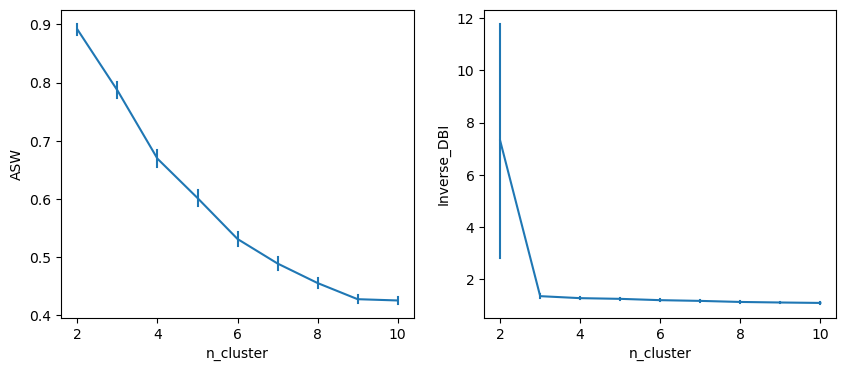

In [31]:
# plot results
plt.figure(figsize = (10, 4))
plt.subplot(121)
sns.lineplot(data = out_performance_df, x = 'n_cluster', y = 'ASW', err_style="bars", errorbar = 'se')
plt.subplot(122)
sns.lineplot(data = out_performance_df, x = 'n_cluster', y = 'Inverse_DBI', err_style="bars", errorbar = 'se')

In [36]:
# try clustering -> N_cluster determined above

clara = CLARA(n_clusters=5, random_state=0).fit(cluster_attr)
labels = clara.labels_
print(labels)
cluster_df.loc[:, 'cluster'] = labels + 1
cluster_df.head(5)


[3 3 3 ... 0 0 0]


,firm_per_area,emp_per_area,production_per_area,consumption_per_area,ind_diversity,GEOID,cluster
0,0.319819,2.767507,1.378419,1.168517,0.939333,31039,4
1,0.130632,0.830926,0.656194,0.080846,0.906079,53069,4
2,0.012074,0.061364,0.003319,0.003695,0.907844,35011,4
3,4.079612,81.725907,0.850147,9.033379,0.786049,31109,5
4,0.138799,0.960866,0.147634,0.337575,0.905880,31129,4


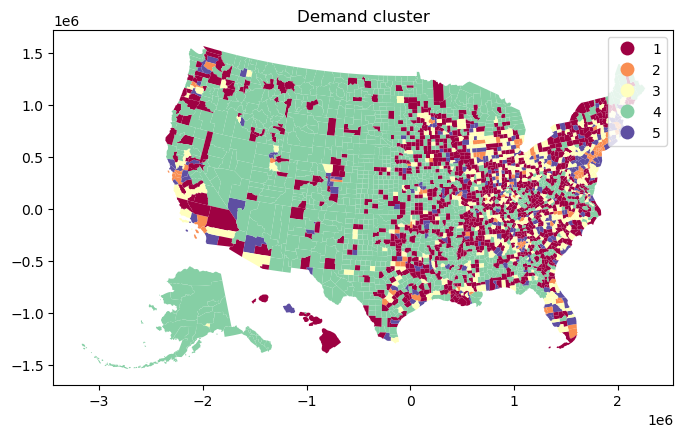

In [37]:
# plot clustering results
county_map_with_cluster = us_counties.merge(cluster_df, on='GEOID', how='inner')
county_map_with_cluster['cluster'] = county_map_with_cluster['cluster'].astype(str)
ax = county_map_with_cluster.plot(figsize = (8,6), column = 'cluster', 
                            legend=True,
                              cmap='Spectral',
                              linewidth=0.01, 
#                             legend_kwds = {'shrink': 0.6}, 
                                  edgecolor='none')
# cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
# ax.set_xlim(-125,-62)
# ax.set_ylim(24,50)
ax.grid(False)
plt.title('Demand cluster')
plt.savefig(os.path.join(plot_dir, 'county_demand_cluster.png'), dpi = 300)

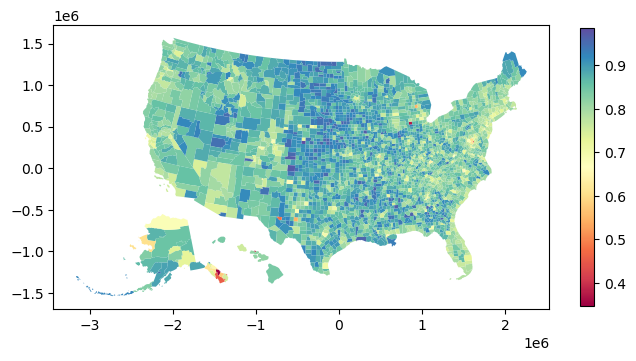

In [38]:
ax = county_map_with_cluster.plot(figsize = (8,6), column = 'ind_diversity', 
                            legend=True,
                              cmap='Spectral',
                              linewidth=0.01, 
                            legend_kwds = {'shrink': 0.6}, 
                                  edgecolor='none')
# cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
# ax.set_xlim(-125,-62)
# ax.set_ylim(24,50)
ax.grid(False)
# plt.title('Demand cluster')
plt.savefig(os.path.join(plot_dir, 'county_ind_diveristy.png'), dpi = 300)

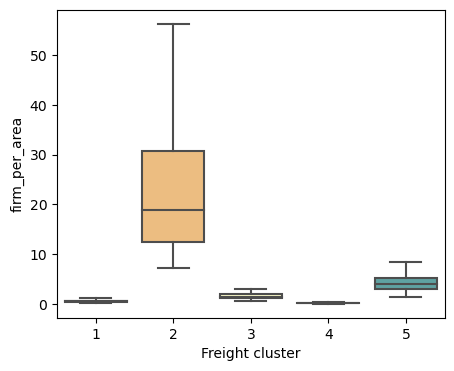

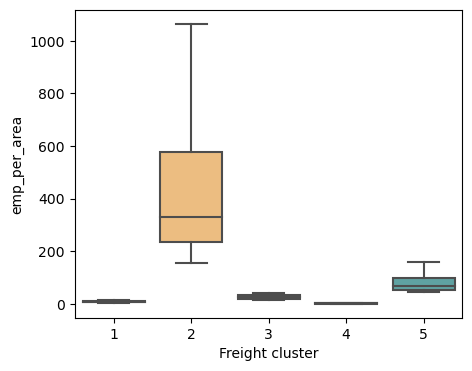

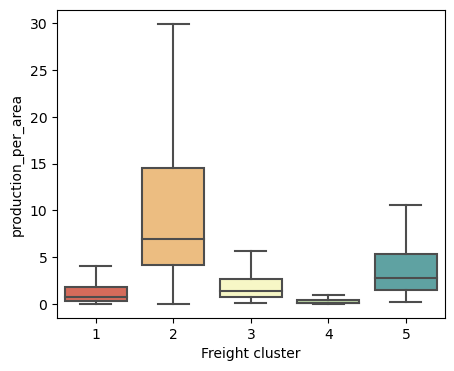

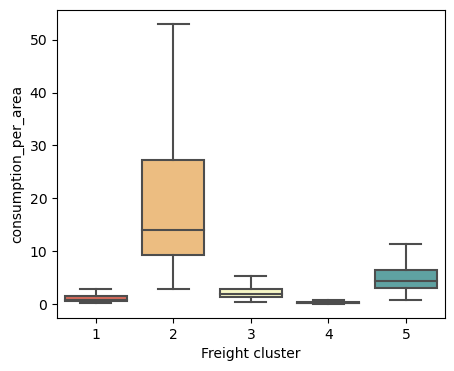

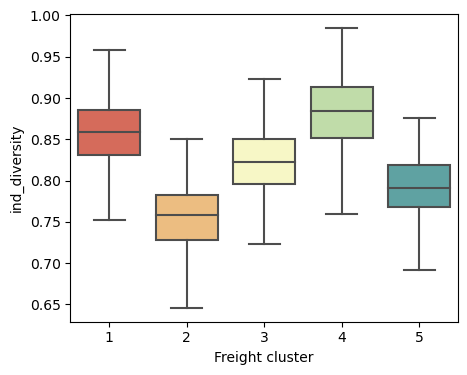

In [39]:
# plot variation of feature by cluster

for feature in features:
    plt.figure(figsize = (5, 4))
    sns.boxplot(data = cluster_df, x = "cluster", 
                y = feature, 
                palette='Spectral',
                showfliers=False)
#     plt.xticks(rotation = 60, ha = 'right')
    plt.xlabel('Freight cluster')

    plt.savefig(os.path.join(plot_dir, 'box_plot_for_' + feature + '.png'), dpi = 300,
               bbox_inches = 'tight')
    plt.show()